# 17章 オートエンコーダとGANを使った表現学習と生成型学習

[https://www.youtube.com/watch?v=vFpZrxaq5xU&t=271s](https://www.youtube.com/watch?v=vFpZrxaq5xU&t=271s)<br>
[https://www.sbbit.jp/article/cont1/57345](https://www.sbbit.jp/article/cont1/57345)
https://qiita.com/LicaOka/items/1f4d1131af05fe30674e

◆オートエンコーダとは<br>
- ニューラルネットワークを利用した教師無し機械学習の手法の1つ。
- 入力と出力が同じ、つまり「問題」と「答え」が同じ問題を学習させる
 ![pic1](fig/pic1.png)
 ![pic2](fig/pic2.png)
- 入力層(左)と出力層(右)のニューロンに比べて中間層(中央)のニューロンが少ない為、情報の特徴を捉えた取捨選択が必要となる。
- 一部のオートエンコーダは生成モデル(generative model)にもなる
    - 生成モデルは、訓練データとよく似た感じのデータを無作為に生成できる。但し、このようにして得られた画像は通常不鮮明であまりリアルではない
- それに対し、GAN(generative adversarial network:敵対的生成ネットワーク)が生成した顔の画像は説得力がありそのような顔の人が存在しないとは信じられないくらいの顔になる
- StyleGAN という新しいGANアーキテクチャが生成した顔の画像が以下で表示される
 https://thispersondoesnotexist.com/
　　https://thisrentaldoesnotexist.com/
- 現在GANは幅広い目的で使われている
    - 超解像度、カラライゼーション、強力な画像編集、動画の次のフレーム予測、データセットの拡張等

## 17.1 効率のよいデータ表現

オートエンコーダは入力を見て、それを効率のよい潜
在表現に変換し、入力と近いものを出力する。オートエンコーダは、必ずエンコーダ（encoder、
または認識ネットワーク：recognition network）とデコーダ（decoder、または生成ネットワー
ク：generative network）の2 つの部分から構成される。エンコーダが入力を潜在表現に変換し、
デコーダが潜在表現を出力に変換する（図17-1 参照）。

![17_1](fig/17_1.png)

ここからもわかるように、オートエンコーダは、出力層のニューロンが入力数と等しくなけれ
ばならないことを除けば、MLP（Multi-Layer Perception：多層パーセプトロン、10 章参照）と
同じアーキテクチャになっている。この例では、2 つのニューロン（エンコーダ）から構成され
る1 つの隠れ層と3 つのニューロン（デコーダ）から構成される出力層があるだけだ。オートエン
コーダは入力を作り直そうとするので、出力は再構築（reconstruction）と呼ばれることが多い。
そして、コスト関数には、再構築が入力と異なるときにモデルにペナルティを与える再構築ロス
（reconstruction loss）が含まれる。

内部表現は、入力データよりも次数が低いため（3D ではなく2D になっている）、オートエンコーダは不完備（undercomplete）だと言われる。不完備なオートエンコーダは、入力を単純にコーディングにコピーすることはできないので、入力のコピーを出力する方法を探さなければならない。入力データのなかでもっとも重要な特徴量がどれか（そして、そうでない特徴量を捨てること）を学ばざるを得なくなるのである。
では、次元削減用の単純な不完備オートエンコーダの作り方を見てみよう。

## 17.2 不完備線形オートエンコーダによるPCA

### Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

オートエンコーダが線形活性化しか使わず、コスト関数がMSE（平均二乗誤差）しか使わないなら、それは結局PCA（主成分分析、8 章参照）を行っているのだと示すことができる。次のコードは、3Dデータセットを対象としてPCAを実行し2Dに射影する単純な線形オートエンコーダを作る。

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

このコードは、実際には今までの章で作ってきたMLPと大差はないが、注意すべきポイントがいくつかある。
- エンコーダとデコーダの2 つのサブコンポーネントを持つものとしてオートエンコーダを構成したこと。どちらも1つのDense層を持つ普通のSequentialモデルで、オートエンコーダは、エンコーダのうしろにデコーダが続くSequentialモデルになっている（モデルはほかのモデルのなかで層として使えることを思い出そう）。
- オートエンコーダの出力数と入力数が等しいこと（つまり、3）。
- 単純なPCAを実行するために、活性化関数を作らない（つまり、すべてのニューロンが線形）で、コスト関数がMSE だということ。もっと複雑なオートエンコーダはすぐあとで示す。では、生成された単純な3 次元データセットでモデルを訓練し、そのモデルで同じデータセットをエンコード（つまり2 次元に投影）してみよう。

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)
# 入力と答えに同じx_trainを使用している

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 1ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


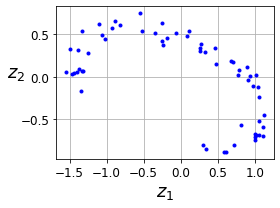

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

![17_2](fig/17_2.png)

## 17.3 スタックオートエンコーダ

https://agirobots.com/deep-learning-2020-ae1/

オートエンコーダの基本系は以下の３階層。それ以上の隠れ層を持つことができ、スタックオートエンコーダ
または深層オートエンコーダと呼ばれる。

層を増やせば、オート
エンコーダはもっと複雑なコーディングを学習しやすくなる。しかし、オートエンコーダは、あま
り強力にしすぎないように注意しなければならない。きわめて強力なために、個々の入力を単一の
無作為な数値に変換してしまうオートエンコーダを想像してみよう（デコーダは逆の変換を学習す
る）。そのようなオートエンコーダは訓練データを完全に再構築するだろうが、その過程で使える
データ表現を学習することはないだろう（そして、新しいインスタンスに対してうまく汎化しない
はずだ）。
スタックオートエンコーダのアーキテクチャは、一般に中央の隠れ層（コーディング層）を中心
として対称的に作られる。平たく言えば、サンドイッチのようになる。たとえば、MNIST（3 章参照）用のオートエンコーダは784 個の入力を持ち、100 個のニューロンを持つ隠れ層、30 個の
ニューロンを持つ中央の隠れ層、100 個のニューロンを持つ第3 の隠れ層、最後に794 個のニュー
ロンを持つ出力層が続く。図17-3 は、スタックオートエンコーダを示している。

![17_3](fig/17_3.png)

### 17.3.1 Kerasによるスタックオートエンコーダの実装

スタックオートエンコーダは、通常の深層MLPと同じように作ることができる。特に注目すべ
きは、11 章でDNNを訓練するために使ったのと同じテクニックが使えることだ。たとえば、次のコードは、SELU活性化関数を使って、Fashion MNIST（10 章でロード、正規化したもの）用のスタックオートエンコーダを作っている。

In [7]:
# MNIST取り込み
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

- 以前と同じように、オートエンコーダモデルをエンコーダとデコーダの2 つのサブモデルに分割している。
- エンコーダは、28 × 28 ピクセルのグレイスケール画像を受け付け、それを平坦化して個々の画像がサイズ784 のベクトルで表現されるようにしてから、サイズを縮小する（まず100ユニットに、次に30 ユニットに）2 つのDense 層（ともにSELU活性化関数を使っている。ルカン正規初期化も追加した方がよいかもしれないが、ネットワークが小さいのでそれほど大きな違いは出ない）で処理している。エンコーダは、個々の入力に対してサイズが30 のベクトルを出力する。
- デコーダは、サイズが30のコーディング（エンコーダの出力）を受け取り、2個のDense層でサイズを拡大する（まず100ユニットに、次に784ユニットに）。そして、最終的なベクトルの形を28×28配列に変換し、デコーダ出力がエンコーダ入力と同じ形になるようにする。
- スタックオートエンコーダのコンパイルでは、平均二乗誤差ではなく、二項交差エントロピー損失関数を使う。再構築タスクを多ラベル二項分類問題として扱っているのである。個々のピクセルの明度は、ピクセルを黒にすべき確率を表す。回帰問題ではなく、このような枠組みの問題にすると、収束が早くなる†2。
- 最後に、X_trainを入力とターゲットの両方として使ってモデルを訓練する（同様に、検証入力、ターゲットとしてもX_trainを使っている）。

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3173 - val_rounded_accuracy: 0.8989
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3056 - rounded_accuracy: 0.9151 - val_loss: 0.3020 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2984 - val_rounded_accuracy: 0.9201
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2949 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

### 17.3.2 再構築の可視化

In [10]:
def plot_image(image):
    plt.imshow(image,cmap="binary")
    plt.axis("off")

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


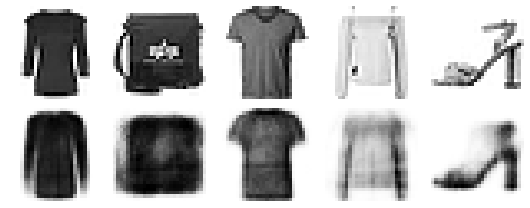

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

再構築は見分けがつく状態ではあるが、少し劣化が激しすぎる。訓練を長くするか、エンコー
ダとデコーダをもっと深くするか、コーディングを大きくする必要があるかもしれない。しかし、
ネットワークを強力にし過ぎると、データのなかの使えるパターンを学習せずに完全な再構築を作
ろうとするようになる。さしあたりは、このモデルで満足することにしよう。

### 17.3.3 Fashion MNISTデータセットの可視化

スタックオートエンコーダを訓練したので、それを使ってデータセットの次元削減をしてみよう。オートエンコーダは、ほかの次元削減アルゴリズム（8 章で取り上げたもの）と比べて、可視化ではそれほどすばらしい結果を生み出すわけではないが、インスタンス、特徴量が多い大規模なデータセットを処理できるという大きな利点を持っている。そこで、オートエンコーダを使って扱いやすいレベルまで次元削減してから、別の次元削減アルゴリズムで可視化するとよい。この方法でFashion MNISTを可視化してみよう。まず、スタックオートエンコーダのエンコーダ部分を使って次元を30 まで下げてから、scikit-learn のt-SNE 実装を使って可視化できる2 まで次元を下げる。<br>
https://qiita.com/g-k/items/120f1cf85ff2ceae4aba

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

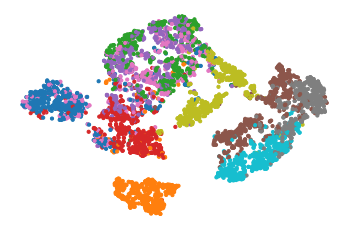

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


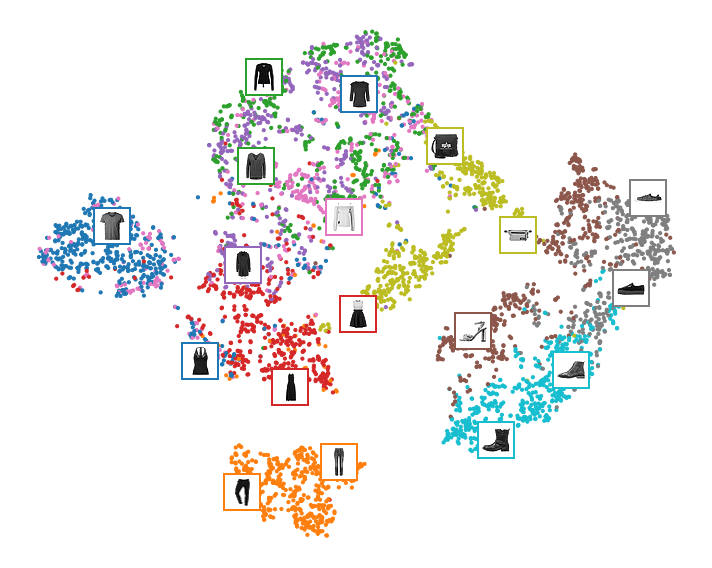

In [15]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

オートエンコーダは、このように次元削減に使えるが、教師無し事前学習にも使える

### 17.3.4 スタックオートエンコーダを使った教師なし事前学習

11 章でも説明したように、複雑な教師ありタスクに取り組んでいるものの、ラベル付きの訓練
データがあまりない場合の対処方法の1 つは、同じようなタスクを実行するニューラルネットワー
クを見つけてきて、その下位層を再利用することだ。すると、既存のネットワークが学習した特徴
量検出器を再利用して下位特徴量をいちいち学習しなくても済むようになるので、わずかな訓練
データで高性能のモデルを作ることができる。
同様に、大規模なデータセットはあるものの、その大半にラベルがついていない場合には、ま
ずすべてのデータを使ってスタックオートエンコーダを訓練し、実際のタスクを行うニューラル
ネットワークを作るときにその下位層を再利用してラベル付きデータで訓練すればよい。たとえ
ば、図17-6 は、スタックオートエンコーダを使って分類用のニューラルネットワークのために教
師なし事前学習を行う方法を示している。分類器を訓練するときに、本当にラベル付き訓練データ
があまりない場合には、事前学習済みの層（少なくとも下位のいくつかの層）を凍結するとよい。

・

![17_6](fig/17_6.png)

ラベルなしデータが山ほどあっても、ラベル付きデータはほとんどないことはよくある。大規
模なラベルなしのデータセットは低コストで作れても（たとえば、簡単なスクリプトを書けば、
インターネットから数百万のイメージをダウンロードできる）、確実なラベル（たとえば、イ
メージがかわいいかどうか）は人間でなければ付けられない。インスタンスにラベルを付ける
には時間とコストがかかる。そのため、ラベル付きインスタンスは数千個しか作らないことは
ごく普通にある。

実装に特別なところは何もない。すべての訓練データ（ラベル付きとラベルなし）を使ってオー
トエンコーダを訓練し、新しいニューラルネットワークを作るときにそのエンコーダ層を再利用す
るだけである（具体例は、章末の演習問題を参照）。
では次に、スタックオートエンコーダを訓練するためのテクニックを少し見ておこう。

# 次元削減

- スッキリわかるPythonによる機械学習入門14章
- 実践機械学習8章<br>
- https://laid-back-scientist.com/pca-theory

## 次元削減とは<br>
- 教師なし学習の1つ
- モデルにデータを与えると、モデルが各列の特徴を調べ、関連する列の特徴をまとめて新しい1つの列(特徴量)に要約→結果として元のデータより列数が減る
- 実際に測定できる構成要素を組み合わせることで実際には測定できない概念的な指標の作成が可能

![14_4](fig/14_4.png)

### 主成分分析とは<br>
- 次元削減の手法の1つで、もっとも代表的な手法
- 各列の相関を考慮して傾向が似ているかどうかを判断し、1列にまとめる

◆相関が強い場合<br>
![14_6](fig/14_6.png)

◆相関があまり強くない場合<br>
- 新しい軸上でのデータの分散値が最大となるような軸を選ぶ
- なぜなら、新しい軸での分散が大きいほど、元データの情報を反映していると解釈できるため
- 逆に分散が小さいと、元の情報をたくさん削ぎ落としており多様性がなくなっていると解釈できる

![14_7](fig/14_7.png)<br>
- 決定した新しい軸を、「固有ベクトル」または「主成分」と呼ぶ
    - 2次元のデータから作成した場合、[0.7, 0.4]などのように2個の数値の数列で表現できる
    - 例えば数学が60点、理科が50点の人の場合、次のように計算できる<br><br>

$$
\begin{align}
    理系能力 &= 0.7*60 + 0.4*50 \\
    &= 42 + 20 \\
    &= 62\\
\end{align}
$$

![14_8](fig/14_8.png)<br><br>
- 新しい列の名称は分析者が考える<br>
![14_9](fig/14_9.png)

- 新しい列は、全ての既存列から大なり小なり影響を受けている<br>
![14_10](fig/14_10.png)

#### データの前処理

In [16]:
import pandas as pd
df = pd.read_csv('Boston.csv')
df.head(2)

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,high,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.7,7.12,27.5
1,low,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.6,27.71,13.2


In [17]:
df2= df.fillna(df.mean())

In [18]:
# ダミー変数化
dummy = pd.get_dummies(df2['CRIME'],drop_first=True)
df3=df2.join(dummy)
df3=df3.drop(['CRIME'],axis=1)

df3.head(2)

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,low,very_low
0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.7,7.12,27.5,0,0
1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.6,27.71,13.2,1,0


In [19]:
# データの標準化
from sklearn.preprocessing import StandardScaler

df4=df3.astype('float')

sc=StandardScaler()
sc_df=sc.fit_transform(df4)

#### 主成分分析の実施

In [20]:
import sklearn
from sklearn.decomposition import PCA
model = PCA(n_components=2, whiten=True)

◆n_compornentsは固有ベクトルの数を定義
- 既存列をいくつの「新たな列」にまとめるかを指定する
- 理論上、軸は既存データの次元の数(列数)だけ、新しい軸を作成することができる<br>

◆白色化
- 今回のデータにおける白色化とは、主成分分析の結果に対して標準化を行った結果と解釈できる

In [21]:
model.fit(sc_df)

PCA(n_components=2, whiten=True)

In [22]:
#　新規の第１軸(第1主成分とも呼ぶ)の固有ベクトル
print(model.components_[0])
print('------')
#　新規の第2軸(第2主成分とも呼ぶ)の固有ベクトル
print(model.components_[1])

[-0.2258543   0.35923465  0.04220985  0.3499321  -0.19485285  0.29792086
 -0.29980115  0.30726517  0.32822012  0.16246983 -0.18251937  0.27543839
 -0.2018449   0.03831172 -0.31492126]
------
[-0.1533893   0.02835867  0.19795373  0.13817925  0.4047141   0.20058802
 -0.29340246 -0.1027543  -0.11546952 -0.34046929  0.05661836 -0.17845386
  0.44390529  0.42253976 -0.27716437]


In [23]:
# 既存のsc_dfを新しい2つの軸に当てはめる
new = model.transform(sc_df)

new_df = pd.DataFrame(new)
new_df.head(3)


,0,1
0,1.490417,-0.680415
1,0.703223,-0.252517
2,-1.403756,-0.613175


元データを新しい軸の固有ベクトルに当てはめた新しい値を主成分得点と呼ぶ
モデル変数.transform(表データ)

#### 結果の評価

■主成分負荷量の確認
- 新しい列と既存の列との関係を考える際には、主成分負荷量を確認する
- 標準化済のデータで主成分分析を行った場合、「標準化済データ」と「主成分得点」との相関関数を求めると、それが主成分負荷量となる

In [24]:
new_df.columns = ['PC1','PC2']
#　標準化済の既存データ(numpy)をデータフレーム化
df5=pd.DataFrame(sc_df,columns=df4.columns)
df6=pd.concat([df5,new_df],axis=1)

In [25]:
df_corr = df6.corr()
df_corr.loc[:'very_low','PC1':]

,PC1,PC2
ZN,-0.560802,-0.226097
INDUS,0.891989,0.041801
CHAS,0.104808,0.291786
NOX,0.868891,0.203678
RM,-0.483825,0.596553
AGE,0.739745,0.295669
DIS,-0.744414,-0.432478
RAD,0.762947,-0.151461
TAX,0.814979,-0.170203
PTRATIO,0.403417,-0.501855


In [26]:
pc_corr = df_corr.loc[:'very_low','PC1':]
pc_corr['PC1'].sort_values(ascending=False)

INDUS       0.891989
NOX         0.868891
TAX         0.814979
RAD         0.762947
AGE         0.739745
LSTAT       0.683921
PTRATIO     0.403417
CHAS        0.104808
low         0.095129
B          -0.453200
RM         -0.483825
PRICE      -0.501186
ZN         -0.560802
DIS        -0.744414
very_low   -0.781958
Name: PC1, dtype: float64

<AxesSubplot:xlabel='City', ylabel='Exclusive residential'>

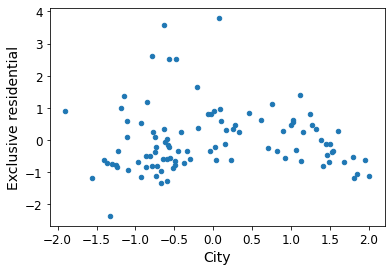

In [27]:
col = ['City','Exclusive residential']
new_df.columns=col
new_df.plot(kind='scatter',x='City', y='Exclusive residential')